# Hill Climbing - Antenna Placement (Basic)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set, Dict
from enum import Enum
import time
import random

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Constants and Antenna Specifications

Three antenna types: Small, Medium, Large.

In [9]:
USERS_PER_HOUSE = 100

class AntennaType(str, Enum):
    SMALL = "Small"
    MEDIUM = "Medium"
    LARGE = "Large"

class AntennaSpec:
    def __init__(self, type: AntennaType, radius: int, cost: int):
        self.type = type
        self.radius = radius
        self.cost = cost

ANTENNA_SPECS = {
    AntennaType.SMALL: AntennaSpec(AntennaType.SMALL, radius=2, cost=1000),
    AntennaType.MEDIUM: AntennaSpec(AntennaType.MEDIUM, radius=4, cost=1500),
    AntennaType.LARGE: AntennaSpec(AntennaType.LARGE, radius=6, cost=2000),
}

print("Antenna Specifications:") 
for spec in ANTENNA_SPECS.values():
    print(f"  {spec.type.value}(radius={spec.radius}, cost=${spec.cost})")

Antenna Specifications:
  Small(radius=2, cost=$1000)
  Medium(radius=4, cost=$1500)
  Large(radius=6, cost=$2000)


## Implement Hill Climbing Class

Basic hill climbing: start with random solution, generate neighbors by changing one cell, accept better neighbor, stop when no improvement.

1.Places antennas on a 2D grid to cover all houses while minimizing cost.

2.Represents solutions as a grid of integers: 0 = no antenna, 1/2/3 = small/medium/large.

3.Uses hill climbing: iteratively moves to the neighbor with the best coverage-cost score.

4.Penalizes incomplete coverage heavily; outputs antenna positions, total cost, and houses covered.

In [98]:
class HillClimbingAlgorithm:
    def __init__(self, width: int, height: int, antenna_specs: Dict[AntennaType, AntennaSpec], houses: List[Tuple[int,int]]):
        self.width = width
        self.height = height
        self.antenna_specs = antenna_specs
        self.houses = set(houses)
        self.total_houses = len(self.houses)
        self.coverage_radius_map = {AntennaType.SMALL: antenna_specs[AntennaType.SMALL].radius,
                                    AntennaType.MEDIUM: antenna_specs[AntennaType.MEDIUM].radius,
                                    AntennaType.LARGE: antenna_specs[AntennaType.LARGE].radius}
        self.cost_map = {t: antenna_specs[t].cost for t in antenna_specs}
        self.positions = [(x,y) for x in range(width) for y in range(height)]
    
    def is_valid_position(self, pos):
        return pos not in self.houses
    
    def get_covered_houses_by_antenna(self, x, y, radius):
        covered = set()
        for hx, hy in self.houses:
            if ((x-hx)**2 + (y-hy)**2)**0.5 <= radius:
                covered.add((hx, hy))
        return covered
    
    def decode_solution(self, sol):
        # sol is list of ints length W*H where 0=no antenna, 1=small,2=med,3=large
        ants = []
        for idx, v in enumerate(sol):
            if v != 0:
                x,y = self.positions[idx]
                t = {1:AntennaType.SMALL, 2:AntennaType.MEDIUM, 3:AntennaType.LARGE}[v]
                ants.append({'x':x,'y':y,'type':t,'radius':self.coverage_radius_map[t],'cost':self.cost_map[t]})
        return ants
    
    def objective(self, sol):
        ants = self.decode_solution(sol)
        covered = set()
        total_cost = 0
        for a in ants:
            covered |= self.get_covered_houses_by_antenna(a['x'], a['y'], a['radius'])
            total_cost += a['cost']
        users_covered = len(covered) * USERS_PER_HOUSE
        total_users = self.total_houses * USERS_PER_HOUSE
        # Penalize solutions that do not cover all houses heavily
        if len(covered) < self.total_houses:
            penalty = -1e6 - total_cost
            return penalty
        # Score prefers lower cost among full-coverage solutions
        score = -(total_cost)
        return score

    def random_solution(self, p_place=0.05):
        sol = []
        for _ in range(self.width * self.height):
            r = random.random()
            if r < p_place:
                sol.append(random.choice([1,2,3]))
            else:
                sol.append(0)
        return sol

    def neighbors(self, sol):
        neighs = []
        n = len(sol)
        for i in range(n):
            s2 = sol.copy()
            cur = s2[i]
            choices = [0,1,2,3]
            choices.remove(cur)
            s2[i] = random.choice(choices)
            neighs.append(s2)
        return neighs

    def best_neighbor(self, sol):
        best = sol
        best_score = self.objective(sol)
        for nsol in self.neighbors(sol):
            s = self.objective(nsol)
            if s > best_score:
                best_score = s
                best = nsol
        return best, best_score

    def run(self, max_iters=1000):
        current = self.random_solution(p_place=0.05)
        current_score = self.objective(current)
        it = 0
        while it < max_iters:
            it += 1
            neigh, neigh_score = self.best_neighbor(current)
            if neigh_score > current_score:
                current = neigh
                current_score = neigh_score
            else:
                break
        ants = self.decode_solution(current)
        covered = set()
        total_cost = 0
        for a in ants:
            covered |= self.get_covered_houses_by_antenna(a['x'], a['y'], a['radius'])
            total_cost += a['cost']
        return {'antennas': ants, 'houses_covered': len(covered), 'total_houses': self.total_houses, 'total_cost': total_cost, 'execution_time_ms': 0}

## Create Sample Grid

Generate random house positions and run hill climbing.

In [92]:
np.random.seed(42)
GRID_WIDTH = 20
GRID_HEIGHT = 15
num_houses = int(GRID_WIDTH * GRID_HEIGHT * 0.15)
houses = []
while len(houses) < num_houses:
    x = np.random.randint(0, GRID_WIDTH)
    y = np.random.randint(0, GRID_HEIGHT)
    if (x,y) not in houses:
        houses.append((x,y))

print(f"Grid size: {GRID_WIDTH}x{GRID_HEIGHT}") 
print(f"Number of houses: {len(houses)}") 
print(f"Total users: {len(houses) * USERS_PER_HOUSE}")

algorithm = HillClimbingAlgorithm(width=GRID_WIDTH, height=GRID_HEIGHT, antenna_specs=ANTENNA_SPECS, houses=houses)
start = time.time()
result = algorithm.run()
result['execution_time_ms'] = (time.time()-start)*1000
result

Grid size: 20x15
Number of houses: 45
Total users: 4500


{'antennas': [{'x': 2,
   'y': 11,
   'type': <AntennaType.MEDIUM: 'Medium'>,
   'radius': 4,
   'cost': 1500},
  {'x': 3,
   'y': 4,
   'type': <AntennaType.LARGE: 'Large'>,
   'radius': 6,
   'cost': 2000},
  {'x': 7,
   'y': 0,
   'type': <AntennaType.LARGE: 'Large'>,
   'radius': 6,
   'cost': 2000},
  {'x': 9,
   'y': 14,
   'type': <AntennaType.LARGE: 'Large'>,
   'radius': 6,
   'cost': 2000},
  {'x': 17,
   'y': 3,
   'type': <AntennaType.LARGE: 'Large'>,
   'radius': 6,
   'cost': 2000},
  {'x': 17,
   'y': 8,
   'type': <AntennaType.LARGE: 'Large'>,
   'radius': 6,
   'cost': 2000}],
 'houses_covered': 45,
 'total_houses': 45,
 'total_cost': 11500,
 'execution_time_ms': 1106.555461883545}

## Visualize Results

Houses (red squares), Antennas (colored by type), Coverage areas (transparent circles).

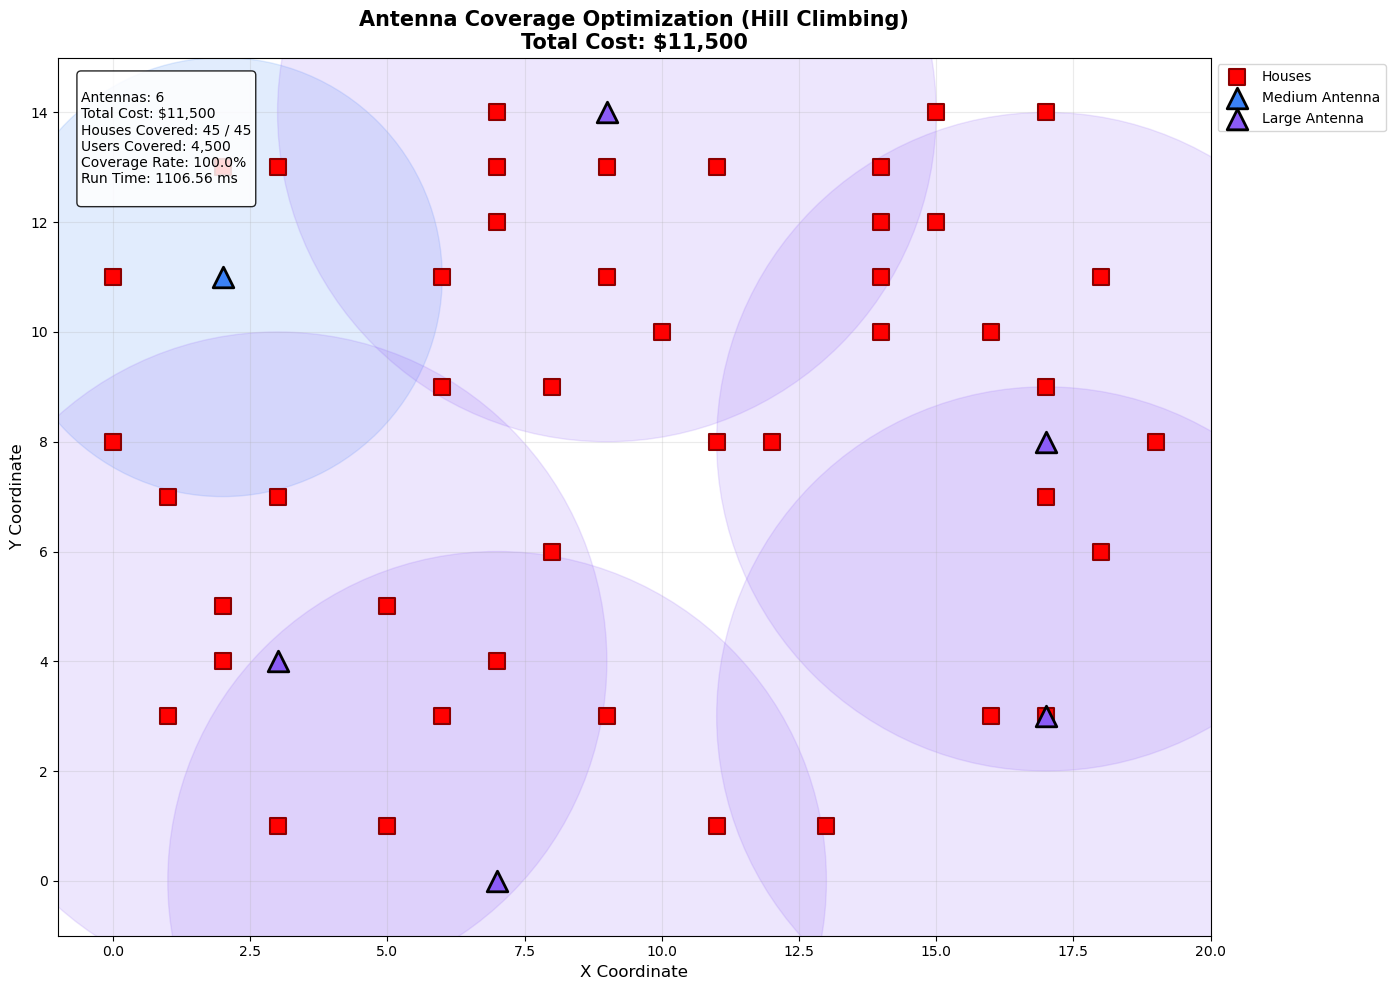

In [94]:
fig, ax = plt.subplots(figsize=(14,10))

# Colors for antennas
antenna_colors = {
    AntennaType.SMALL:  '#10B981',  # Green
    AntennaType.MEDIUM: '#3B82F6',  # Blue
    AntennaType.LARGE:  '#8B5CF6'   # Purple
}

# --- Draw antenna coverage circles ---
for ant in result['antennas']:
    ax.add_patch(plt.Circle(
        (ant['x'], ant['y']),
        ant['radius'],
        color = antenna_colors[ant['type']],
        alpha = 0.15,
        zorder = 1
    ))

# --- Draw houses ---
if houses:
    hx, hy = zip(*houses)
    ax.scatter(
        hx, hy,
        c='red',
        s=120,
        marker='s',
        edgecolors='darkred',
        linewidth=1.5,
        label='Houses',
        zorder=3
    )

# --- Group antennas by type ---
grouped = {}
for ant in result['antennas']:
    grouped.setdefault(ant['type'], {'x':[], 'y':[]})
    grouped[ant['type']]['x'].append(ant['x'])
    grouped[ant['type']]['y'].append(ant['y'])

# --- Draw antenna icons ---
for ant_type, coords in grouped.items():
    ax.scatter(
        coords['x'], coords['y'],
        c=antenna_colors[ant_type],
        s=220,
        marker='^',
        edgecolors='black',
        linewidth=2,
        label=f'{ant_type.value} Antenna',
        zorder=4
    )

# --- Layout ---
ax.set_xlim(-1, GRID_WIDTH)
ax.set_ylim(-1, GRID_HEIGHT)
ax.set_aspect('equal')
ax.grid(True, alpha=0.25)

ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(
    f'Antenna Coverage Optimization (Hill Climbing)\nTotal Cost: ${result["total_cost"]:,}',
    fontsize=15, fontweight='bold'
)

# --- Statistics box ---
stats = f"""
Antennas: {len(result['antennas'])}
Total Cost: ${result['total_cost']:,}
Houses Covered: {result['houses_covered']} / {result['total_houses']}
Users Covered: {result['houses_covered'] * USERS_PER_HOUSE:,}
Coverage Rate: {result['houses_covered'] / result['total_houses'] * 100:.1f}%
Run Time: {result['execution_time_ms']:.2f} ms
"""

ax.text(
    0.02, 0.98, stats,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


## Test with Different Grid Sizes

Test algorithm on multiple densities and print comparison.

In [96]:
# ---------------------------------------------------------
# TEST HILL CLIMBING ALGORITHM WITH DIFFERENT GRID SETTINGS
# ---------------------------------------------------------

test_configs = [
    {"width": 15, "height": 15, "density": 0.10, "name": "Low Density (10%)"},
    {"width": 20, "height": 15, "density": 0.15, "name": "Medium Density (15%)"},
    {"width": 25, "height": 20, "density": 0.20, "name": "High Density (20%)"},
]

results_comparison = []

for config in test_configs:
    print("\n" + "=" * 70)
    print(f"TEST: {config['name']} - {config['width']}x{config['height']} grid")
    print("=" * 70)

    # --- Generate unique house coordinates ---
    np.random.seed(42)
    num_houses = int(config["width"] * config["height"] * config["density"])

    all_positions = [
        (x, y)
        for x in range(config["width"])
        for y in range(config["height"])
    ]

    # Randomly sample unique house positions
    test_houses = list(np.random.choice(
        len(all_positions),
        size=num_houses,
        replace=False
    ))

    test_houses = [all_positions[i] for i in test_houses]

    # --- Run Algorithm ---
    algorithm = HillClimbingAlgorithm(
        width=config["width"],
        height=config["height"],
        antenna_specs=ANTENNA_SPECS,
        houses=test_houses
    )

    start = time.time()
    result = algorithm.run()
    exec_time_ms = (time.time() - start) * 1000

    users = result["total_houses"] * USERS_PER_HOUSE
    cost_per_user = result["total_cost"] / users if users > 0 else 0

    # Store results
    results_comparison.append({
        "name": config["name"],
        "houses": num_houses,
        "users": users,
        "antennas": len(result["antennas"]),
        "cost": result["total_cost"],
        "cost_per_user": cost_per_user,
        "exec_time_ms": exec_time_ms
    })




TEST: Low Density (10%) - 15x15 grid

TEST: Medium Density (15%) - 20x15 grid

TEST: High Density (20%) - 25x20 grid


## Algorithm Summary



Key Features:
- Hill-climbing approach: starts with a random layout and repeatedly switches to a better neighboring layout.

Representation:
 -Each grid cell holds one antenna type or remains empty.

Goal:
 -Full coverage with minimum total cost.

How it works:

1.Start with a random configuration

2.Generate neighbors by modifying one antenna placement

3.Evaluate coverage + cost

4.Move to the best improving neighbor

5.Stop when no neighbor provides improvement

In [ ]:
# Hill Climbing (pseudo-code)
S = random_solution()

while True:
    neighbors = generate_neighbors(S)
    S_best = best(neighbors)

    if score(S_best) > score(S):
        S = S_best
    else:
        break   # local optimum

return S


In [ ]:
2. Paramètres

Voisinage : comment on modifie la solution (ajout/suppression/changement d’antenne).

Fonction d’évaluation : calcule couverture + coût.

Condition d’arrêt : aucune amélioration possible.

In [ ]:
3. Application au problème

. Représenter la grille : chaque case = type d’antenne ou vide.

. Générer voisins : modifier 1 case.

.Évaluer : maisons couvertes + coût.

Le Hill Climbing améliore la configuration jusqu’à bloquer sur un optimum local.

In [ ]:
4. Complexité

Soient :

W × H = taille de la grille

T = nombre de types d’antennes

I = nombre d’itérations jusqu’à convergence

Nombre de voisins par itération :
≈ W × H × T

Complexité totale :

O(I × W × H × T)
#justif:
À chaque itération, on génère environ W × H × T voisins (on modifie une case avec T types possibles).
Chaque voisin doit être évalué, ce qui dépend des N maisons.
On répète cela pendant I itérations jusqu’à l’optimum local.